In [33]:
import pandas as pd
from graph_tool import Graph
from netpixi.data.gt import *
import netpixi
from graph_tool import centrality
import seaborn as sns
import matplotlib.pyplot as plt
from graph_tool import clustering
import cpnet
import statsmodels.formula.api as smf
from graph_tool import spectral
from matplotlib import rcParams
import numpy as np
from math import sqrt, isnan
import csv

# Importando o Dataset

In [2]:
!pip install opendatasets

In [2]:
import opendatasets as od

ModuleNotFoundError: No module named 'opendatasets'

In [4]:
od.download("https://www.kaggle.com/stackoverflow/stacksample")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vergarac
Your Kaggle Key: ········


100%|██████████| 1.11G/1.11G [02:14<00:00, 8.86MB/s]


# Lendo os Dados

In [3]:
tags = pd.read_csv("stacksample/Tags.csv")

In [4]:
df_tags = tags
df_tags.Id = df_tags.Id.astype(str)
df_tags = (tags.groupby(['Tag'])
    .agg({'Id': lambda x: ",".join(x)})
    .reset_index())
# tags['Id'].head()
df_tags.head()

,Tag,Id
0,.a,"2488400,6211950,6267900,14914830,15292510,1720..."
1,.app,"1822660,7073520,7525060,10015770,12519610,1263..."
2,.aspxauth,"2646310,10419880,14369430,18112270,22258970,25..."
3,.bash-profile,"1240750,4060880,9050490,11498070,11692100,1452..."
4,.class-file,"6386570,9297570,9956870,12209970,15131040,1613..."


In [5]:
df_tags['Quantity'] = df_tags.Id.apply(lambda x: len(x))
df_tags.sort_values(by=['Quantity'], ascending=False).head()

,Tag,Id,Quantity
16121,javascript,"7540,15390,19280,19970,20510,23620,25240,27030...",1097767
16020,java,"4080,4630,7720,10980,11930,12870,15690,16140,2...",1013837
4301,c#,"260,650,930,1010,1040,1760,2250,2780,4610,4850...",880631
24211,php,"2900,4430,7470,10990,12870,13000,13620,24130,3...",867889
979,android,"28380,146020,365880,455830,468220,522800,52351...",800875


In [6]:
df_tags[df_tags["Tag"]=="javascript"]

,Tag,Id,Quantity
16121,javascript,"7540,15390,19280,19970,20510,23620,25240,27030...",1097767


In [7]:
tags = pd.read_csv("stacksample/Tags.csv")
quests = pd.read_csv("stacksample/Questions.csv", encoding='ISO-8859-1', engine='python')
answ = pd.read_csv("stacksample/Answers.csv", encoding='ISO-8859-1', engine='python')

In [8]:
#filtrando perguntas apenas para aquelas de 2016 
quests = quests[(quests['CreationDate'] >= '2016-10-00T00:00:00Z')]

In [9]:
#numero total de perguntas em 2016
quests.shape[0]

14590

In [10]:
#filtrando as tags para pegar apenas as dos posts de 2016
tags = tags[tags['Id'].isin(quests['Id'])]

In [11]:
answ = answ[answ['ParentId'].isin(quests['Id'])]

In [12]:
quests.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
1249626,39801640,4913444.0,2016-10-01T00:01:54Z,NaN,-1,EasyMapping map property one-way,<p>I've searched the docs and examples of Easy...
1249627,39801660,2800840.0,2016-10-01T00:06:05Z,NaN,0,Assign Global Variable Inside Class From Class...,<p>I have a question about classes in Python. ...
1249628,39801670,4114997.0,2016-10-01T00:07:20Z,NaN,0,Http PUT in Angular2 to .NET Core Web API give...,<p>I have an Angular2 app which does an http P...
1249629,39801690,1079379.0,2016-10-01T00:10:25Z,2016-10-01T13:49:44Z,-1,exporting a 3d object generated with iOS metalkit,<p>Given a 3d object generated by something li...
1249630,39801710,6907047.0,2016-10-01T00:13:07Z,NaN,0,A member test using Recursion,<p>I was having trouble understanding recursio...


In [13]:
#quantidade de tags no total (não únicas; cada fileira representa uma tag associada a uma pergunta;uma tag pode ser 
#associada a mais de uma pergunta)
tags.shape[0]

43377

In [14]:
#filtrando as tags para manter apenas as perguntas que possuem duas ou mais tags associadas
tags = tags.groupby('Id').filter(lambda x: len(x) > 2)

In [15]:
#quantidade de tags depois de filtrar
tags.shape[0]

34010

In [16]:
#filtrando as perguntas para ter apenas as com 2 ou mais tags
quests = quests[quests['Id'].isin(tags['Id'])]

In [17]:
#quantidade de perguntas depois de filtrar
quests.shape[0]

8977

In [84]:
df_tags = tags
df_tags.Id = df_tags.Id.astype(str)
df_tags = (tags.groupby(['Tag'])
    .agg({'Id': lambda x: ",".join(x)})
    .reset_index())
# tags['Id'].head()
df_tags['Quantity'] = df_tags.Id.apply(lambda x: len(x.split(",")))
df_tags.sort_values(by=['Quantity'], ascending=False).head()
df_tags.head()


,Tag,Id,Quantity
0,.class-file,39947580,1
1,.doc,39891660,1
2,.htaccess,"39805910,39817440,39829850,39868410,39871670,3...",41
3,.htpasswd,39884060,1
4,.net,"39804470,39809050,39811010,39817390,39826280,3...",105


In [85]:
data = quests.set_index("Id")
data.head()

,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
Id,,,,,,
39801640,4913444.0,2016-10-01T00:01:54Z,NaN,-1,EasyMapping map property one-way,<p>I've searched the docs and examples of Easy...
39801660,2800840.0,2016-10-01T00:06:05Z,NaN,0,Assign Global Variable Inside Class From Class...,<p>I have a question about classes in Python. ...
39801670,4114997.0,2016-10-01T00:07:20Z,NaN,0,Http PUT in Angular2 to .NET Core Web API give...,<p>I have an Angular2 app which does an http P...
39801690,1079379.0,2016-10-01T00:10:25Z,2016-10-01T13:49:44Z,-1,exporting a 3d object generated with iOS metalkit,<p>Given a 3d object generated by something li...
39801720,6907046.0,2016-10-01T00:14:16Z,NaN,0,How do I use pygame's draw() module to draw sh...,<p>I'm adapting gui15.py from the examples pro...


In [86]:
quests.loc[quests["Id"] == 39884060 ]

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
1253112,39884060,6222411.0,2016-10-05T21:32:47Z,NaN,-1,protect a specific page with htaccess and htpa...,"<p>when we use htaccess and htpasswd, </p>\n\n..."


In [93]:
listaRendimento = list()
for tags_items, row in df_tags.iterrows():
    i = 0
    lista = row['Id'].split(',')
    tag = row['Tag']
    listDates = list()
    for ids in lista:
        listDates.append(data.loc[int(ids),"ClosedDate"])
    for items in listDates:
        if pd.notnull(items):
            i+=1
    if i != 0:
        i = 1000000*(i/int(row["Quantity"]))
    listaRendimento.append(int(i))    


In [94]:
print(listaRendimento)

[1000000, 0, 73170, 0, 85714, 0, 0, 0, 0, 0, 0, 0, 0, 285714, 500000, 1000000, 0, 0, 0, 222222, 1000000, 0, 0, 250000, 0, 0, 0, 0, 0, 0, 200000, 0, 0, 0, 0, 1000000, 0, 1000000, 0, 0, 0, 250000, 0, 0, 0, 0, 0, 0, 200000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000000, 0, 0, 0, 0, 0, 0, 333333, 0, 0, 0, 0, 0, 0, 0, 200000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 85271, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 190476, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 52631, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19230, 0, 0, 0, 0, 0, 0, 0, 0, 500000, 0, 200000, 66844, 0, 0, 250000, 200000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 111111, 0, 0, 0, 0, 0, 0, 0, 166666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 200000, 0, 0, 500000, 0, 1000000, 0, 0, 0, 0, 0, 0, 0, 0, 142857, 0, 0, 0, 0, 0, 0, 0, 0, 333333, 0, 90909, 0, 0, 0, 0, 75000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 142857, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [95]:
quests['ClosedDate'].value_counts()


2016-10-01T13:49:44Z    1
2016-10-13T16:34:08Z    1
2016-10-14T00:49:35Z    1
2016-10-13T18:27:07Z    1
2016-10-13T14:51:26Z    1
                       ..
2016-10-07T19:19:06Z    1
2016-10-07T10:21:17Z    1
2016-10-07T13:23:02Z    1
2016-10-07T14:11:18Z    1
2016-10-19T23:06:30Z    1
Name: ClosedDate, Length: 686, dtype: int64

In [96]:
df_tags["Rendimento"] = listaRendimento
df_tags.head()

,Tag,Id,Quantity,Rendimento
0,.class-file,39947580,1,1000000
1,.doc,39891660,1,0
2,.htaccess,"39805910,39817440,39829850,39868410,39871670,3...",41,73170
3,.htpasswd,39884060,1,0
4,.net,"39804470,39809050,39811010,39817390,39826280,3...",105,85714


# Fazendo o grafo

In [102]:
#setup do grafo
g = Graph(directed=False) # não dirigido
g.vp['name'] = g.new_vp('object')
g.vp['rendimento'] = g.new_vp('object')
g.ep['counter'] = g.new_ep('object')

In [103]:
# adiciona vertice de uma tag ao grafo
def addTag(tag, list_tags, rendimento):
    g.add_vertex()
    list_tags.append(tag)
    v_tag = g.vertex(list_tags.index(tag))
    g.vp['name'][v_tag] = str(tag)
    g.vp['rendimento'][v_tag] = int(rendimento)

In [104]:
#adiciona aresta ao grafo quando duas tags estão presentes na mesma pergunta
def addConnec(tag1, tag2):
    index1 = list_tags.index(tag1)
    index2 = list_tags.index(tag2)
    
    if g.edge(index1, index2) == None:
        g.add_edge(index1, index2)
        e=g.edge(index1, index2)
        g.ep['counter'][e] = 1
    else:
        e=g.edge(index1, index2)
        g.ep['counter'][e] = g.ep['counter'][e] + 1

In [105]:
list_tags = []
for tagIndex in range(tags.shape[0] - 2):
    tag = tags.iloc[tagIndex]['Tag']
    tagId = tags.iloc[tagIndex]['Id']  #esse Id representa a pergunta a qual a tag em questao pertence
    rendimento = df_tags.loc[df_tags["Tag"] == tag, "Rendimento"]
    
    #se o vertice da tag nao existir ainda cria o vertice
    if tag not in list_tags:
        addTag(tag, list_tags, rendimento)
    print("Tag atual:")
    print(tag)
    
    sameQuest = 1
    i=1

    while sameQuest == 1:
        nextTag = tags.iloc[(tagIndex + i)]['Tag']
        nextId = tags.iloc[(tagIndex + i)]['Id']
        nextRend = df_tags.loc[df_tags["Tag"] == nextTag, "Rendimento"]

        if tagId == nextId:
            if nextTag not in list_tags:
                addTag(nextTag, list_tags, nextRend)
                
            print(nextTag)
            addConnec(tag, nextTag)
        else:
            sameQuest = 0
            print("prox vertice")
            break
        
        if ((tagIndex + i) < (tags.shape[0] - 1)):
            i += 1
        else:
            sameQuest = 0
            break

Tag atual:
ios
objective-c
core-data
prox vertice
Tag atual:
objective-c
core-data
prox vertice
Tag atual:
core-data
prox vertice
Tag atual:
python
python-2.7
class
prox vertice
Tag atual:
python-2.7
class
prox vertice
Tag atual:
class
prox vertice
Tag atual:
c#
angular2
asp.net-core
cors
asp.net-core-webapi
prox vertice
Tag atual:
angular2
asp.net-core
cors
asp.net-core-webapi
prox vertice
Tag atual:
asp.net-core
cors
asp.net-core-webapi
prox vertice
Tag atual:
cors
asp.net-core-webapi
prox vertice
Tag atual:
asp.net-core-webapi
prox vertice
Tag atual:
ios
opengl-es
3d
metalkit
prox vertice
Tag atual:
opengl-es
3d
metalkit
prox vertice
Tag atual:
3d
metalkit
prox vertice
Tag atual:
metalkit
prox vertice
Tag atual:
python
pygame
pgu
prox vertice
Tag atual:
pygame
pgu
prox vertice
Tag atual:
pgu
prox vertice
Tag atual:
linux
multithreading
asynchronous
sqlite3
real-time
prox vertice
Tag atual:
multithreading
asynchronous
sqlite3
real-time
prox vertice
Tag atual:
asynchronous
sqlite3
rea

prox vertice
Tag atual:
c#
asp.net-mvc
lambda
prox vertice
Tag atual:
asp.net-mvc
lambda
prox vertice
Tag atual:
lambda
prox vertice
Tag atual:
ios
delegates
protocols
swift3
prox vertice
Tag atual:
delegates
protocols
swift3
prox vertice
Tag atual:
protocols
swift3
prox vertice
Tag atual:
swift3
prox vertice
Tag atual:
image
matlab
linear-algebra
camera-calibration
prox vertice
Tag atual:
matlab
linear-algebra
camera-calibration
prox vertice
Tag atual:
linear-algebra
camera-calibration
prox vertice
Tag atual:
camera-calibration
prox vertice
Tag atual:
python
python-3.x
typeerror
self
prox vertice
Tag atual:
python-3.x
typeerror
self
prox vertice
Tag atual:
typeerror
self
prox vertice
Tag atual:
self
prox vertice
Tag atual:
c#
asp.net
tcp
tcpclient
prox vertice
Tag atual:
asp.net
tcp
tcpclient
prox vertice
Tag atual:
tcp
tcpclient
prox vertice
Tag atual:
tcpclient
prox vertice
Tag atual:
java
android
mysql
android-contentprovider
android-database
prox vertice
Tag atual:
android
mysql
a

Tag atual:
angular2-services
angular2-http
prox vertice
Tag atual:
angular2-http
prox vertice
Tag atual:
android
profiling
nvidia
prox vertice
Tag atual:
profiling
nvidia
prox vertice
Tag atual:
nvidia
prox vertice
Tag atual:
asp.net
telerik
telerik-grid
prox vertice
Tag atual:
telerik
telerik-grid
prox vertice
Tag atual:
telerik-grid
prox vertice
Tag atual:
php
wordpress
forms
prox vertice
Tag atual:
wordpress
forms
prox vertice
Tag atual:
forms
prox vertice
Tag atual:
android
android-volley
traffic
prox vertice
Tag atual:
android-volley
traffic
prox vertice
Tag atual:
traffic
prox vertice
Tag atual:
php
mysql
sql-server
asterisk
symfony3
prox vertice
Tag atual:
mysql
sql-server
asterisk
symfony3
prox vertice
Tag atual:
sql-server
asterisk
symfony3
prox vertice
Tag atual:
asterisk
symfony3
prox vertice
Tag atual:
symfony3
prox vertice
Tag atual:
java
regex
string
parsing
prox vertice
Tag atual:
regex
string
parsing
prox vertice
Tag atual:
string
parsing
prox vertice
Tag atual:
parsing

postgresql
hibernate
jpa
prox vertice
Tag atual:
postgresql
hibernate
jpa
prox vertice
Tag atual:
hibernate
jpa
prox vertice
Tag atual:
jpa
prox vertice
Tag atual:
asp.net-mvc
twitter-bootstrap
less
v8
bundletransformer
prox vertice
Tag atual:
twitter-bootstrap
less
v8
bundletransformer
prox vertice
Tag atual:
less
v8
bundletransformer
prox vertice
Tag atual:
v8
bundletransformer
prox vertice
Tag atual:
bundletransformer
prox vertice
Tag atual:
ios
objective-c
multithreading
cocoa-touch
afnetworking
prox vertice
Tag atual:
objective-c
multithreading
cocoa-touch
afnetworking
prox vertice
Tag atual:
multithreading
cocoa-touch
afnetworking
prox vertice
Tag atual:
cocoa-touch
afnetworking
prox vertice
Tag atual:
afnetworking
prox vertice
Tag atual:
python
python-2.7
python-3.x
prox vertice
Tag atual:
python-2.7
python-3.x
prox vertice
Tag atual:
python-3.x
prox vertice
Tag atual:
javascript
regex
algorithm
object
split
prox vertice
Tag atual:
regex
algorithm
object
split
prox vertice
Tag a

Tag atual:
clock
prox vertice
Tag atual:
asp.net
angularjs
asp.net-web-api
prox vertice
Tag atual:
angularjs
asp.net-web-api
prox vertice
Tag atual:
asp.net-web-api
prox vertice
Tag atual:
android
action
launcher
shortcuts
prox vertice
Tag atual:
action
launcher
shortcuts
prox vertice
Tag atual:
launcher
shortcuts
prox vertice
Tag atual:
shortcuts
prox vertice
Tag atual:
java
swing
jtextarea
netbeans-8
caret
prox vertice
Tag atual:
swing
jtextarea
netbeans-8
caret
prox vertice
Tag atual:
jtextarea
netbeans-8
caret
prox vertice
Tag atual:
netbeans-8
caret
prox vertice
Tag atual:
caret
prox vertice
Tag atual:
replace
emacs
mouse
prox vertice
Tag atual:
emacs
mouse
prox vertice
Tag atual:
mouse
prox vertice
Tag atual:
c#
reflection
portable-class-library
redefinition
prox vertice
Tag atual:
reflection
portable-class-library
redefinition
prox vertice
Tag atual:
portable-class-library
redefinition
prox vertice
Tag atual:
redefinition
prox vertice
Tag atual:
java
spring
jsp
date
spring-mvc
p

Tag atual:
vim
encoding
character-encoding
vi
iso-8859-1
prox vertice
Tag atual:
encoding
character-encoding
vi
iso-8859-1
prox vertice
Tag atual:
character-encoding
vi
iso-8859-1
prox vertice
Tag atual:
vi
iso-8859-1
prox vertice
Tag atual:
iso-8859-1
prox vertice
Tag atual:
c#
timer
label
fade
prox vertice
Tag atual:
timer
label
fade
prox vertice
Tag atual:
label
fade
prox vertice
Tag atual:
fade
prox vertice
Tag atual:
python
pyspark
dropbox
spark-dataframe
prox vertice
Tag atual:
pyspark
dropbox
spark-dataframe
prox vertice
Tag atual:
dropbox
spark-dataframe
prox vertice
Tag atual:
spark-dataframe
prox vertice
Tag atual:
java
multithreading
task
real-time
lejos-nxj
prox vertice
Tag atual:
multithreading
task
real-time
lejos-nxj
prox vertice
Tag atual:
task
real-time
lejos-nxj
prox vertice
Tag atual:
real-time
lejos-nxj
prox vertice
Tag atual:
lejos-nxj
prox vertice
Tag atual:
java
android
google-maps
distance
android-maps-v2
prox vertice
Tag atual:
android
google-maps
distance
andr

responsive
prox vertice
Tag atual:
css
mobile
responsive
prox vertice
Tag atual:
mobile
responsive
prox vertice
Tag atual:
responsive
prox vertice
Tag atual:
java
android
c++
class
prox vertice
Tag atual:
android
c++
class
prox vertice
Tag atual:
c++
class
prox vertice
Tag atual:
class
prox vertice
Tag atual:
css
wordpress
flexslider
prox vertice
Tag atual:
wordpress
flexslider
prox vertice
Tag atual:
flexslider
prox vertice
Tag atual:
windows
keyboard-shortcuts
autohotkey
prox vertice
Tag atual:
keyboard-shortcuts
autohotkey
prox vertice
Tag atual:
autohotkey
prox vertice
Tag atual:
python
apache-spark
jupyter
sampling
prox vertice
Tag atual:
apache-spark
jupyter
sampling
prox vertice
Tag atual:
jupyter
sampling
prox vertice
Tag atual:
sampling
prox vertice
Tag atual:
mysql
hive
hdfs
sqoop
prox vertice
Tag atual:
hive
hdfs
sqoop
prox vertice
Tag atual:
hdfs
sqoop
prox vertice
Tag atual:
sqoop
prox vertice
Tag atual:
mysql
hadoop
import
bigdata
apache-kafka
prox vertice
Tag atual:
hado

centos
postfix
prox vertice
Tag atual:
centos
postfix
prox vertice
Tag atual:
postfix
prox vertice
Tag atual:
ruby-on-rails
ruby
caching
prox vertice
Tag atual:
ruby
caching
prox vertice
Tag atual:
caching
prox vertice
Tag atual:
c#
wpf
xaml
combobox
prox vertice
Tag atual:
wpf
xaml
combobox
prox vertice
Tag atual:
xaml
combobox
prox vertice
Tag atual:
combobox
prox vertice
Tag atual:
java
osx
selenium
selenium-webdriver
appium-ios
prox vertice
Tag atual:
osx
selenium
selenium-webdriver
appium-ios
prox vertice
Tag atual:
selenium
selenium-webdriver
appium-ios
prox vertice
Tag atual:
selenium-webdriver
appium-ios
prox vertice
Tag atual:
appium-ios
prox vertice
Tag atual:
ldap
freebsd
openldap
ldif
prox vertice
Tag atual:
freebsd
openldap
ldif
prox vertice
Tag atual:
openldap
ldif
prox vertice
Tag atual:
ldif
prox vertice
Tag atual:
css
iphone
device-width
prox vertice
Tag atual:
iphone
device-width
prox vertice
Tag atual:
device-width
prox vertice
Tag atual:
excel
vba
excel-vba
collecti

visual-studio-2013
administrator
prox vertice
Tag atual:
ssl
iis
visual-studio-2013
administrator
prox vertice
Tag atual:
iis
visual-studio-2013
administrator
prox vertice
Tag atual:
visual-studio-2013
administrator
prox vertice
Tag atual:
administrator
prox vertice
Tag atual:
javascript
html
css
canvas
prox vertice
Tag atual:
html
css
canvas
prox vertice
Tag atual:
css
canvas
prox vertice
Tag atual:
canvas
prox vertice
Tag atual:
c++
c
extern
prox vertice
Tag atual:
c
extern
prox vertice
Tag atual:
extern
prox vertice
Tag atual:
javascript
ionic-framework
firebase
firebase-database
angularfire
prox vertice
Tag atual:
ionic-framework
firebase
firebase-database
angularfire
prox vertice
Tag atual:
firebase
firebase-database
angularfire
prox vertice
Tag atual:
firebase-database
angularfire
prox vertice
Tag atual:
angularfire
prox vertice
Tag atual:
java
ios
objective-c
swift
porting
prox vertice
Tag atual:
ios
objective-c
swift
porting
prox vertice
Tag atual:
objective-c
swift
porting
pro

prox vertice
Tag atual:
vba
bootstrapping
prox vertice
Tag atual:
bootstrapping
prox vertice
Tag atual:
debugging
reset
pic
microchip
mplab
prox vertice
Tag atual:
reset
pic
microchip
mplab
prox vertice
Tag atual:
pic
microchip
mplab
prox vertice
Tag atual:
microchip
mplab
prox vertice
Tag atual:
mplab
prox vertice
Tag atual:
php
mysql
wordpress
chat
prox vertice
Tag atual:
mysql
wordpress
chat
prox vertice
Tag atual:
wordpress
chat
prox vertice
Tag atual:
chat
prox vertice
Tag atual:
arrays
algorithm
numbers
sequence
prox vertice
Tag atual:
algorithm
numbers
sequence
prox vertice
Tag atual:
numbers
sequence
prox vertice
Tag atual:
sequence
prox vertice
Tag atual:
osx
google-chrome
safari
swift3
macos-sierra
prox vertice
Tag atual:
google-chrome
safari
swift3
macos-sierra
prox vertice
Tag atual:
safari
swift3
macos-sierra
prox vertice
Tag atual:
swift3
macos-sierra
prox vertice
Tag atual:
macos-sierra
prox vertice
Tag atual:
c++
opengl
rendering
vbo
prox vertice
Tag atual:
opengl
rende

definition
prox vertice
Tag atual:
declaration
definition
prox vertice
Tag atual:
definition
prox vertice
Tag atual:
python
ipython
python-import
prox vertice
Tag atual:
ipython
python-import
prox vertice
Tag atual:
python-import
prox vertice
Tag atual:
java
android
sdk
prox vertice
Tag atual:
android
sdk
prox vertice
Tag atual:
sdk
prox vertice
Tag atual:
oracle
plsql
oracle11g
user-defined-types
prox vertice
Tag atual:
plsql
oracle11g
user-defined-types
prox vertice
Tag atual:
oracle11g
user-defined-types
prox vertice
Tag atual:
user-defined-types
prox vertice
Tag atual:
javascript
html
checkbox
prox vertice
Tag atual:
html
checkbox
prox vertice
Tag atual:
checkbox
prox vertice
Tag atual:
python
sql
database
client
prox vertice
Tag atual:
sql
database
client
prox vertice
Tag atual:
database
client
prox vertice
Tag atual:
client
prox vertice
Tag atual:
html
autocomplete
sublimetext2
prox vertice
Tag atual:
autocomplete
sublimetext2
prox vertice
Tag atual:
sublimetext2
prox vertice
Tag

Tag atual:
c#
visual-studio
stylecop
prox vertice
Tag atual:
visual-studio
stylecop
prox vertice
Tag atual:
stylecop
prox vertice
Tag atual:
javascript
function
function-call
prox vertice
Tag atual:
function
function-call
prox vertice
Tag atual:
function-call
prox vertice
Tag atual:
python
xml
text
python-3.5
prox vertice
Tag atual:
xml
text
python-3.5
prox vertice
Tag atual:
text
python-3.5
prox vertice
Tag atual:
python-3.5
prox vertice
Tag atual:
python
string
boolean
variable-assignment
prox vertice
Tag atual:
string
boolean
variable-assignment
prox vertice
Tag atual:
boolean
variable-assignment
prox vertice
Tag atual:
variable-assignment
prox vertice
Tag atual:
c#
asp.net-mvc
backload
prox vertice
Tag atual:
asp.net-mvc
backload
prox vertice
Tag atual:
backload
prox vertice
Tag atual:
visual-studio
qt
testing
build
cmake
prox vertice
Tag atual:
qt
testing
build
cmake
prox vertice
Tag atual:
testing
build
cmake
prox vertice
Tag atual:
build
cmake
prox vertice
Tag atual:
cmake
prox 

sklearn-pandas
prox vertice
Tag atual:
scikit-learn
cross-validation
sklearn-pandas
prox vertice
Tag atual:
cross-validation
sklearn-pandas
prox vertice
Tag atual:
sklearn-pandas
prox vertice
Tag atual:
bash
shell
unix
command-line
prox vertice
Tag atual:
shell
unix
command-line
prox vertice
Tag atual:
unix
command-line
prox vertice
Tag atual:
command-line
prox vertice
Tag atual:
angularjs
angularjs-ng-route
angular-template
prox vertice
Tag atual:
angularjs-ng-route
angular-template
prox vertice
Tag atual:
angular-template
prox vertice
Tag atual:
spring
authentication
spring-security
spring-boot
x509certificate
prox vertice
Tag atual:
authentication
spring-security
spring-boot
x509certificate
prox vertice
Tag atual:
spring-security
spring-boot
x509certificate
prox vertice
Tag atual:
spring-boot
x509certificate
prox vertice
Tag atual:
x509certificate
prox vertice
Tag atual:
ios
app-store
itunesconnect
prox vertice
Tag atual:
app-store
itunesconnect
prox vertice
Tag atual:
itunesconnect

Tag atual:
ios
objective-c
uiscrollview
prox vertice
Tag atual:
objective-c
uiscrollview
prox vertice
Tag atual:
uiscrollview
prox vertice
Tag atual:
facebook
facebook-graph-api
laravel-5.2
facebook-php-sdk
prox vertice
Tag atual:
facebook-graph-api
laravel-5.2
facebook-php-sdk
prox vertice
Tag atual:
laravel-5.2
facebook-php-sdk
prox vertice
Tag atual:
facebook-php-sdk
prox vertice
Tag atual:
sparql
jena
semantic-web
wordnet
prox vertice
Tag atual:
jena
semantic-web
wordnet
prox vertice
Tag atual:
semantic-web
wordnet
prox vertice
Tag atual:
wordnet
prox vertice
Tag atual:
caching
header
footer
httpmodule
prox vertice
Tag atual:
header
footer
httpmodule
prox vertice
Tag atual:
footer
httpmodule
prox vertice
Tag atual:
httpmodule
prox vertice
Tag atual:
android
google-maps
debugging
prox vertice
Tag atual:
google-maps
debugging
prox vertice
Tag atual:
debugging
prox vertice
Tag atual:
ios
swift
swift3
prox vertice
Tag atual:
swift
swift3
prox vertice
Tag atual:
swift3
prox vertice
Tag 

swifty-json
prox vertice
Tag atual:
postman
swifty-json
prox vertice
Tag atual:
swifty-json
prox vertice
Tag atual:
python
html
sqlite
prox vertice
Tag atual:
html
sqlite
prox vertice
Tag atual:
sqlite
prox vertice
Tag atual:
javascript
jquery
html
css
prox vertice
Tag atual:
jquery
html
css
prox vertice
Tag atual:
html
css
prox vertice
Tag atual:
css
prox vertice
Tag atual:
android
canvas
rect
porter-duff
prox vertice
Tag atual:
canvas
rect
porter-duff
prox vertice
Tag atual:
rect
porter-duff
prox vertice
Tag atual:
porter-duff
prox vertice
Tag atual:
amazon-web-services
sdk
builder
aws-kinesis-firehose
prox vertice
Tag atual:
sdk
builder
aws-kinesis-firehose
prox vertice
Tag atual:
builder
aws-kinesis-firehose
prox vertice
Tag atual:
aws-kinesis-firehose
prox vertice
Tag atual:
excel
vba
excel-vba
prox vertice
Tag atual:
vba
excel-vba
prox vertice
Tag atual:
excel-vba
prox vertice
Tag atual:
c++
class
oop
opencv
tracking
prox vertice
Tag atual:
class
oop
opencv
tracking
prox vertice


Tag atual:
sandbox
java-security
prox vertice
Tag atual:
java-security
prox vertice
Tag atual:
c#
linq
object
hierarchy
relationships
prox vertice
Tag atual:
linq
object
hierarchy
relationships
prox vertice
Tag atual:
object
hierarchy
relationships
prox vertice
Tag atual:
hierarchy
relationships
prox vertice
Tag atual:
relationships
prox vertice
Tag atual:
c#
winforms
location
label
prox vertice
Tag atual:
winforms
location
label
prox vertice
Tag atual:
location
label
prox vertice
Tag atual:
label
prox vertice
Tag atual:
vb.net
visual-studio
windows-7
.net-4.5
prox vertice
Tag atual:
visual-studio
windows-7
.net-4.5
prox vertice
Tag atual:
windows-7
.net-4.5
prox vertice
Tag atual:
.net-4.5
prox vertice
Tag atual:
python
string
python-3.x
numpy
prox vertice
Tag atual:
string
python-3.x
numpy
prox vertice
Tag atual:
python-3.x
numpy
prox vertice
Tag atual:
numpy
prox vertice
Tag atual:
java
database
sockets
socket.io
socket-timeout-exception
prox vertice
Tag atual:
database
sockets
sock

authenticode
prox vertice
Tag atual:
sign
authenticode
prox vertice
Tag atual:
authenticode
prox vertice
Tag atual:
azure
azure-sql-database
azure-web-app-service
azure-sql-server
prox vertice
Tag atual:
azure-sql-database
azure-web-app-service
azure-sql-server
prox vertice
Tag atual:
azure-web-app-service
azure-sql-server
prox vertice
Tag atual:
azure-sql-server
prox vertice
Tag atual:
amazon-ec2
command-line-interface
ami
prox vertice
Tag atual:
command-line-interface
ami
prox vertice
Tag atual:
ami
prox vertice
Tag atual:
ruby
operating-system
user
prox vertice
Tag atual:
operating-system
user
prox vertice
Tag atual:
user
prox vertice
Tag atual:
java
random
random-seed
prox vertice
Tag atual:
random
random-seed
prox vertice
Tag atual:
random-seed
prox vertice
Tag atual:
ios
swift
tableview
prox vertice
Tag atual:
swift
tableview
prox vertice
Tag atual:
tableview
prox vertice
Tag atual:
if-statement
prolog
logical-purity
prox vertice
Tag atual:
prolog
logical-purity
prox vertice
Tag 

pthreads
openmp
prox vertice
Tag atual:
pthreads
openmp
prox vertice
Tag atual:
openmp
prox vertice
Tag atual:
asp.net
asp.net-mvc
c#-4.0
asp.net-web-api
prox vertice
Tag atual:
asp.net-mvc
c#-4.0
asp.net-web-api
prox vertice
Tag atual:
c#-4.0
asp.net-web-api
prox vertice
Tag atual:
asp.net-web-api
prox vertice
Tag atual:
python
sql
orm
sqlalchemy
relational-database
prox vertice
Tag atual:
sql
orm
sqlalchemy
relational-database
prox vertice
Tag atual:
orm
sqlalchemy
relational-database
prox vertice
Tag atual:
sqlalchemy
relational-database
prox vertice
Tag atual:
relational-database
prox vertice
Tag atual:
specifications
alloy
reasoning
prox vertice
Tag atual:
alloy
reasoning
prox vertice
Tag atual:
reasoning
prox vertice
Tag atual:
google-apps-script
triggers
google-spreadsheet
sendmail
prox vertice
Tag atual:
triggers
google-spreadsheet
sendmail
prox vertice
Tag atual:
google-spreadsheet
sendmail
prox vertice
Tag atual:
sendmail
prox vertice
Tag atual:
powershell
puppet
puppet-enter

Tag atual:
windows-10-universal
printdocument
prox vertice
Tag atual:
printdocument
prox vertice
Tag atual:
java
android
git
gradle
prox vertice
Tag atual:
android
git
gradle
prox vertice
Tag atual:
git
gradle
prox vertice
Tag atual:
gradle
prox vertice
Tag atual:
regex
system-verilog
uvm
prox vertice
Tag atual:
system-verilog
uvm
prox vertice
Tag atual:
uvm
prox vertice
Tag atual:
angular2
firebase
ionic2
angularfire2
prox vertice
Tag atual:
firebase
ionic2
angularfire2
prox vertice
Tag atual:
ionic2
angularfire2
prox vertice
Tag atual:
angularfire2
prox vertice
Tag atual:
android
http
adapter
device
prox vertice
Tag atual:
http
adapter
device
prox vertice
Tag atual:
adapter
device
prox vertice
Tag atual:
device
prox vertice
Tag atual:
security
ssl-certificate
x509
pki
prox vertice
Tag atual:
ssl-certificate
x509
pki
prox vertice
Tag atual:
x509
pki
prox vertice
Tag atual:
pki
prox vertice
Tag atual:
hibernate
entity
one-to-many
prox vertice
Tag atual:
entity
one-to-many
prox vertice


prox vertice
Tag atual:
controller
prox vertice
Tag atual:
google-apps-script
google-spreadsheet
spreadsheet
prox vertice
Tag atual:
google-spreadsheet
spreadsheet
prox vertice
Tag atual:
spreadsheet
prox vertice
Tag atual:
editor
textures
blender
prox vertice
Tag atual:
textures
blender
prox vertice
Tag atual:
blender
prox vertice
Tag atual:
php
laravel
blade
prox vertice
Tag atual:
laravel
blade
prox vertice
Tag atual:
blade
prox vertice
Tag atual:
networking
protocols
webrtc
p2p
prox vertice
Tag atual:
protocols
webrtc
p2p
prox vertice
Tag atual:
webrtc
p2p
prox vertice
Tag atual:
p2p
prox vertice
Tag atual:
php
crc
xmodem
prox vertice
Tag atual:
crc
xmodem
prox vertice
Tag atual:
xmodem
prox vertice
Tag atual:
javascript
html5
dom
prox vertice
Tag atual:
html5
dom
prox vertice
Tag atual:
dom
prox vertice
Tag atual:
python
scikit-learn
sklearn-pandas
prox vertice
Tag atual:
scikit-learn
sklearn-pandas
prox vertice
Tag atual:
sklearn-pandas
prox vertice
Tag atual:
angularjs
ionic-fra

nsattributedstring
prox vertice
Tag atual:
grand-central-dispatch
nsattributedstring
prox vertice
Tag atual:
nsattributedstring
prox vertice
Tag atual:
javascript
variables
html-table
prox vertice
Tag atual:
variables
html-table
prox vertice
Tag atual:
html-table
prox vertice
Tag atual:
python
pandas
time-series
regression
prox vertice
Tag atual:
pandas
time-series
regression
prox vertice
Tag atual:
time-series
regression
prox vertice
Tag atual:
regression
prox vertice
Tag atual:
api
oauth-2.0
ckan
prox vertice
Tag atual:
oauth-2.0
ckan
prox vertice
Tag atual:
ckan
prox vertice
Tag atual:
javascript
html
html5-canvas
prox vertice
Tag atual:
html
html5-canvas
prox vertice
Tag atual:
html5-canvas
prox vertice
Tag atual:
sql
amazon-redshift
paraccel
prox vertice
Tag atual:
amazon-redshift
paraccel
prox vertice
Tag atual:
paraccel
prox vertice
Tag atual:
web-services
wcf
soap
paypal
prox vertice
Tag atual:
wcf
soap
paypal
prox vertice
Tag atual:
soap
paypal
prox vertice
Tag atual:
paypal
p

amazon-cloudfront
cloudflare
prox vertice
Tag atual:
amazon-cloudfront
cloudflare
prox vertice
Tag atual:
cloudflare
prox vertice
Tag atual:
sql
psql
rule
prox vertice
Tag atual:
psql
rule
prox vertice
Tag atual:
rule
prox vertice
Tag atual:
ios
json
swift
alamofire
swifty-json
prox vertice
Tag atual:
json
swift
alamofire
swifty-json
prox vertice
Tag atual:
swift
alamofire
swifty-json
prox vertice
Tag atual:
alamofire
swifty-json
prox vertice
Tag atual:
swifty-json
prox vertice
Tag atual:
php
arrays
json
api
curl
prox vertice
Tag atual:
arrays
json
api
curl
prox vertice
Tag atual:
json
api
curl
prox vertice
Tag atual:
api
curl
prox vertice
Tag atual:
curl
prox vertice
Tag atual:
mysql
gps
bigdata
prox vertice
Tag atual:
gps
bigdata
prox vertice
Tag atual:
bigdata
prox vertice
Tag atual:
android
skmaps
android-security
prox vertice
Tag atual:
skmaps
android-security
prox vertice
Tag atual:
android-security
prox vertice
Tag atual:
c++
for-loop
internationalization
output
keystrokes
prox 

json
node.js
express
prox vertice
Tag atual:
json
node.js
express
prox vertice
Tag atual:
node.js
express
prox vertice
Tag atual:
express
prox vertice
Tag atual:
javascript
jquery
python
ajax
python-2.7
prox vertice
Tag atual:
jquery
python
ajax
python-2.7
prox vertice
Tag atual:
python
ajax
python-2.7
prox vertice
Tag atual:
ajax
python-2.7
prox vertice
Tag atual:
python-2.7
prox vertice
Tag atual:
c
max
min
prox vertice
Tag atual:
max
min
prox vertice
Tag atual:
min
prox vertice
Tag atual:
php
cron
windows-server
prox vertice
Tag atual:
cron
windows-server
prox vertice
Tag atual:
windows-server
prox vertice
Tag atual:
c#
wpf
xaml
binding
tooltip
prox vertice
Tag atual:
wpf
xaml
binding
tooltip
prox vertice
Tag atual:
xaml
binding
tooltip
prox vertice
Tag atual:
binding
tooltip
prox vertice
Tag atual:
tooltip
prox vertice
Tag atual:
python
django
google-compute-engine
google-cloud-platform
prox vertice
Tag atual:
django
google-compute-engine
google-cloud-platform
prox vertice
Tag atua

spring-saml
java-api
prox vertice
Tag atual:
saml-2.0
spring-saml
java-api
prox vertice
Tag atual:
spring-saml
java-api
prox vertice
Tag atual:
java-api
prox vertice
Tag atual:
android
cursor
simplecursoradapter
android-cursoradapter
android-cursor
prox vertice
Tag atual:
cursor
simplecursoradapter
android-cursoradapter
android-cursor
prox vertice
Tag atual:
simplecursoradapter
android-cursoradapter
android-cursor
prox vertice
Tag atual:
android-cursoradapter
android-cursor
prox vertice
Tag atual:
android-cursor
prox vertice
Tag atual:
android
cordova
android-studio-2.0
prox vertice
Tag atual:
cordova
android-studio-2.0
prox vertice
Tag atual:
android-studio-2.0
prox vertice
Tag atual:
java
eclipse
jsp
tomcat
servlets
prox vertice
Tag atual:
eclipse
jsp
tomcat
servlets
prox vertice
Tag atual:
jsp
tomcat
servlets
prox vertice
Tag atual:
tomcat
servlets
prox vertice
Tag atual:
servlets
prox vertice
Tag atual:
javascript
json
facebook
react-native
prox vertice
Tag atual:
json
facebook
rea

prox vertice
Tag atual:
sensor
prox vertice
Tag atual:
excel
excel-formula
sumifs
prox vertice
Tag atual:
excel-formula
sumifs
prox vertice
Tag atual:
sumifs
prox vertice
Tag atual:
javascript
sorting
underscore.js
prox vertice
Tag atual:
sorting
underscore.js
prox vertice
Tag atual:
underscore.js
prox vertice
Tag atual:
ios
video
streaming
wowza
m3u8
prox vertice
Tag atual:
video
streaming
wowza
m3u8
prox vertice
Tag atual:
streaming
wowza
m3u8
prox vertice
Tag atual:
wowza
m3u8
prox vertice
Tag atual:
m3u8
prox vertice
Tag atual:
c++
string
pass-by-value
prox vertice
Tag atual:
string
pass-by-value
prox vertice
Tag atual:
pass-by-value
prox vertice
Tag atual:
swift
swift3
tvos
prox vertice
Tag atual:
swift3
tvos
prox vertice
Tag atual:
tvos
prox vertice
Tag atual:
android
android-volley
http-response-codes
prox vertice
Tag atual:
android-volley
http-response-codes
prox vertice
Tag atual:
http-response-codes
prox vertice
Tag atual:
angular2
ionic-framework
ionic2
prox vertice
Tag atua

prox vertice
Tag atual:
php
apache
ubuntu
zend-framework
prox vertice
Tag atual:
apache
ubuntu
zend-framework
prox vertice
Tag atual:
ubuntu
zend-framework
prox vertice
Tag atual:
zend-framework
prox vertice
Tag atual:
ios
iphone
swift
core-data
ios10
prox vertice
Tag atual:
iphone
swift
core-data
ios10
prox vertice
Tag atual:
swift
core-data
ios10
prox vertice
Tag atual:
core-data
ios10
prox vertice
Tag atual:
ios10
prox vertice
Tag atual:
php
lambda
map-function
prox vertice
Tag atual:
lambda
map-function
prox vertice
Tag atual:
map-function
prox vertice
Tag atual:
javascript
jquery
html
each
prox vertice
Tag atual:
jquery
html
each
prox vertice
Tag atual:
html
each
prox vertice
Tag atual:
each
prox vertice
Tag atual:
sql
ruby-on-rails
ruby
postgresql
pivot-table
prox vertice
Tag atual:
ruby-on-rails
ruby
postgresql
pivot-table
prox vertice
Tag atual:
ruby
postgresql
pivot-table
prox vertice
Tag atual:
postgresql
pivot-table
prox vertice
Tag atual:
pivot-table
prox vertice
Tag atual:

esp
prox vertice
Tag atual:
aem
dam
esp
prox vertice
Tag atual:
dam
esp
prox vertice
Tag atual:
esp
prox vertice
Tag atual:
excel
vba
excel-vba
prox vertice
Tag atual:
vba
excel-vba
prox vertice
Tag atual:
excel-vba
prox vertice
Tag atual:
sublimetext2
sublimetext3
webstorm
atom-editor
jsx
prox vertice
Tag atual:
sublimetext3
webstorm
atom-editor
jsx
prox vertice
Tag atual:
webstorm
atom-editor
jsx
prox vertice
Tag atual:
atom-editor
jsx
prox vertice
Tag atual:
jsx
prox vertice
Tag atual:
matlab
error-handling
event-handling
matlab-figure
prox vertice
Tag atual:
error-handling
event-handling
matlab-figure
prox vertice
Tag atual:
event-handling
matlab-figure
prox vertice
Tag atual:
matlab-figure
prox vertice
Tag atual:
php
html
mysql
web
prox vertice
Tag atual:
html
mysql
web
prox vertice
Tag atual:
mysql
web
prox vertice
Tag atual:
web
prox vertice
Tag atual:
html
magento
e-commerce
magento-1.8
prox vertice
Tag atual:
magento
e-commerce
magento-1.8
prox vertice
Tag atual:
e-commerce
ma

onclick
transition
prox vertice
Tag atual:
onclick
transition
prox vertice
Tag atual:
transition
prox vertice
Tag atual:
wpf
alignment
dockpanel
prox vertice
Tag atual:
alignment
dockpanel
prox vertice
Tag atual:
dockpanel
prox vertice
Tag atual:
ruby-on-rails
csv
heroku
prox vertice
Tag atual:
csv
heroku
prox vertice
Tag atual:
heroku
prox vertice
Tag atual:
python
process
subprocess
gdbserver
prox vertice
Tag atual:
process
subprocess
gdbserver
prox vertice
Tag atual:
subprocess
gdbserver
prox vertice
Tag atual:
gdbserver
prox vertice
Tag atual:
npm
sublimetext2
admin
npm-install
prox vertice
Tag atual:
sublimetext2
admin
npm-install
prox vertice
Tag atual:
admin
npm-install
prox vertice
Tag atual:
npm-install
prox vertice
Tag atual:
node.js
authentication
sails.js
waterlock
prox vertice
Tag atual:
authentication
sails.js
waterlock
prox vertice
Tag atual:
sails.js
waterlock
prox vertice
Tag atual:
waterlock
prox vertice
Tag atual:
scala
playframework
playframework-2.0
prox vertice
Ta

prox vertice
Tag atual:
android
bean-validation
ternary-operator
prox vertice
Tag atual:
bean-validation
ternary-operator
prox vertice
Tag atual:
ternary-operator
prox vertice
Tag atual:
javascript
angularjs
angular2
ionic2
prox vertice
Tag atual:
angularjs
angular2
ionic2
prox vertice
Tag atual:
angular2
ionic2
prox vertice
Tag atual:
ionic2
prox vertice
Tag atual:
django
windows
python-3.x
virtualenvwrapper
python-3.6
prox vertice
Tag atual:
windows
python-3.x
virtualenvwrapper
python-3.6
prox vertice
Tag atual:
python-3.x
virtualenvwrapper
python-3.6
prox vertice
Tag atual:
virtualenvwrapper
python-3.6
prox vertice
Tag atual:
python-3.6
prox vertice
Tag atual:
c#
c++
windows
networking
file-sharing
prox vertice
Tag atual:
c++
windows
networking
file-sharing
prox vertice
Tag atual:
windows
networking
file-sharing
prox vertice
Tag atual:
networking
file-sharing
prox vertice
Tag atual:
file-sharing
prox vertice
Tag atual:
regex
linux
sed
redhat
prox vertice
Tag atual:
linux
sed
redhat


prox vertice
Tag atual:
methodexpression
prox vertice
Tag atual:
javascript
audio
html5-audio
hls
hls.js
prox vertice
Tag atual:
audio
html5-audio
hls
hls.js
prox vertice
Tag atual:
html5-audio
hls
hls.js
prox vertice
Tag atual:
hls
hls.js
prox vertice
Tag atual:
hls.js
prox vertice
Tag atual:
javascript
node.js
meteor
prox vertice
Tag atual:
node.js
meteor
prox vertice
Tag atual:
meteor
prox vertice
Tag atual:
c++
vector
stringstream
prox vertice
Tag atual:
vector
stringstream
prox vertice
Tag atual:
stringstream
prox vertice
Tag atual:
python
django
orm
geodjango
prox vertice
Tag atual:
django
orm
geodjango
prox vertice
Tag atual:
orm
geodjango
prox vertice
Tag atual:
geodjango
prox vertice
Tag atual:
using
drive
letters
prox vertice
Tag atual:
drive
letters
prox vertice
Tag atual:
letters
prox vertice
Tag atual:
javascript
jquery
css
prox vertice
Tag atual:
jquery
css
prox vertice
Tag atual:
css
prox vertice
Tag atual:
r
plot
time-series
prox vertice
Tag atual:
plot
time-series
prox

Tag atual:
ply-file-format
prox vertice
Tag atual:
python
user-interface
tkinter
prox vertice
Tag atual:
user-interface
tkinter
prox vertice
Tag atual:
tkinter
prox vertice
Tag atual:
r
version
text-mining
prox vertice
Tag atual:
version
text-mining
prox vertice
Tag atual:
text-mining
prox vertice
Tag atual:
bash
osx
curl
sed
grep
prox vertice
Tag atual:
osx
curl
sed
grep
prox vertice
Tag atual:
curl
sed
grep
prox vertice
Tag atual:
sed
grep
prox vertice
Tag atual:
grep
prox vertice
Tag atual:
python
string
control-characters
prox vertice
Tag atual:
string
control-characters
prox vertice
Tag atual:
control-characters
prox vertice
Tag atual:
c#
autofac
mediatr
prox vertice
Tag atual:
autofac
mediatr
prox vertice
Tag atual:
mediatr
prox vertice
Tag atual:
php
html
fopen
fwrite
prox vertice
Tag atual:
html
fopen
fwrite
prox vertice
Tag atual:
fopen
fwrite
prox vertice
Tag atual:
fwrite
prox vertice
Tag atual:
python
python-2.7
compression
prox vertice
Tag atual:
python-2.7
compression
pro

modeling
motion-detection
3d-modelling
prox vertice
Tag atual:
matlab
modeling
motion-detection
3d-modelling
prox vertice
Tag atual:
modeling
motion-detection
3d-modelling
prox vertice
Tag atual:
motion-detection
3d-modelling
prox vertice
Tag atual:
3d-modelling
prox vertice
Tag atual:
opencv
computer-vision
circle
detection
prox vertice
Tag atual:
computer-vision
circle
detection
prox vertice
Tag atual:
circle
detection
prox vertice
Tag atual:
detection
prox vertice
Tag atual:
breadcrumbs
mvcsitemapprovider
mvcsitemap
sitemapprovider
prox vertice
Tag atual:
mvcsitemapprovider
mvcsitemap
sitemapprovider
prox vertice
Tag atual:
mvcsitemap
sitemapprovider
prox vertice
Tag atual:
sitemapprovider
prox vertice
Tag atual:
python
file
random
prox vertice
Tag atual:
file
random
prox vertice
Tag atual:
random
prox vertice
Tag atual:
ios
objective-c
uibutton
uicollectionview
prox vertice
Tag atual:
objective-c
uibutton
uicollectionview
prox vertice
Tag atual:
uibutton
uicollectionview
prox verti

prox vertice
Tag atual:
javascript
cookies
jwt
bearer-token
prox vertice
Tag atual:
cookies
jwt
bearer-token
prox vertice
Tag atual:
jwt
bearer-token
prox vertice
Tag atual:
bearer-token
prox vertice
Tag atual:
javascript
jquery
modularity
modularization
prox vertice
Tag atual:
jquery
modularity
modularization
prox vertice
Tag atual:
modularity
modularization
prox vertice
Tag atual:
modularization
prox vertice
Tag atual:
ios
objective-c
nsmutablearray
prox vertice
Tag atual:
objective-c
nsmutablearray
prox vertice
Tag atual:
nsmutablearray
prox vertice
Tag atual:
csv
networking
simulation
wireshark
prox vertice
Tag atual:
networking
simulation
wireshark
prox vertice
Tag atual:
simulation
wireshark
prox vertice
Tag atual:
wireshark
prox vertice
Tag atual:
javascript
npm
i18next
prox vertice
Tag atual:
npm
i18next
prox vertice
Tag atual:
i18next
prox vertice
Tag atual:
javascript
jquery
frontend
prox vertice
Tag atual:
jquery
frontend
prox vertice
Tag atual:
frontend
prox vertice
Tag atu

uiview
touches
prox vertice
Tag atual:
uiview
touches
prox vertice
Tag atual:
touches
prox vertice
Tag atual:
c#
xml
xml-validation
xmldiff
prox vertice
Tag atual:
xml
xml-validation
xmldiff
prox vertice
Tag atual:
xml-validation
xmldiff
prox vertice
Tag atual:
xmldiff
prox vertice
Tag atual:
qt
static
static-linking
prox vertice
Tag atual:
static
static-linking
prox vertice
Tag atual:
static-linking
prox vertice
Tag atual:
javascript
requirejs
requirejs-optimizer
prox vertice
Tag atual:
requirejs
requirejs-optimizer
prox vertice
Tag atual:
requirejs-optimizer
prox vertice
Tag atual:
python
jupyter-notebook
plotly
iplots
prox vertice
Tag atual:
jupyter-notebook
plotly
iplots
prox vertice
Tag atual:
plotly
iplots
prox vertice
Tag atual:
iplots
prox vertice
Tag atual:
visual-studio
reporting-services
ssrs-2012
prox vertice
Tag atual:
reporting-services
ssrs-2012
prox vertice
Tag atual:
ssrs-2012
prox vertice
Tag atual:
unix
informatica
informatica-powercenter
prox vertice
Tag atual:
info

Tag atual:
http
spring-mvc
spring-test
prox vertice
Tag atual:
spring-mvc
spring-test
prox vertice
Tag atual:
spring-test
prox vertice
Tag atual:
java
spring
java-ee
process
processbuilder
prox vertice
Tag atual:
spring
java-ee
process
processbuilder
prox vertice
Tag atual:
java-ee
process
processbuilder
prox vertice
Tag atual:
process
processbuilder
prox vertice
Tag atual:
processbuilder
prox vertice
Tag atual:
visual-studio
dll
oculus
prox vertice
Tag atual:
dll
oculus
prox vertice
Tag atual:
oculus
prox vertice
Tag atual:
eclipse
maven
pom.xml
prox vertice
Tag atual:
maven
pom.xml
prox vertice
Tag atual:
pom.xml
prox vertice
Tag atual:
java
android
sdk
sleep
battery
prox vertice
Tag atual:
android
sdk
sleep
battery
prox vertice
Tag atual:
sdk
sleep
battery
prox vertice
Tag atual:
sleep
battery
prox vertice
Tag atual:
battery
prox vertice
Tag atual:
c#
json
dictionary
asp.net-core
datacontract
prox vertice
Tag atual:
json
dictionary
asp.net-core
datacontract
prox vertice
Tag atual:
d

gridview
prox vertice
Tag atual:
gridview
prox vertice
Tag atual:
sql
sql-server
csv
ssis
prox vertice
Tag atual:
sql-server
csv
ssis
prox vertice
Tag atual:
csv
ssis
prox vertice
Tag atual:
ssis
prox vertice
Tag atual:
javascript
jquery
jquery-globalize
prox vertice
Tag atual:
jquery
jquery-globalize
prox vertice
Tag atual:
jquery-globalize
prox vertice
Tag atual:
php
codeigniter
file-upload
prox vertice
Tag atual:
codeigniter
file-upload
prox vertice
Tag atual:
file-upload
prox vertice
Tag atual:
c#
wpf
visual-studio-2013
prox vertice
Tag atual:
wpf
visual-studio-2013
prox vertice
Tag atual:
visual-studio-2013
prox vertice
Tag atual:
java
android
arrays
json


TypeError: cannot convert the series to <class 'int'>

In [106]:
#posicionando vertices de acordo com o algoritmo SFDP, que evidencia "panelinhas"
m = draw_gt.sfdp_layout(g)
move_gt(g, m)
save_gt(g, 'projeto.net.gz')

In [107]:
#rederiza visualizacao do grafo
r = netpixi.render('projeto.net.gz')

In [109]:
#mostra os nomes dos jogadores na visualizacao
#CUIDADO QUE QUANDO VC RODA ISSO O ARQUIVO FICA INFINTAMENTE MAIS PESADO
r.vertex_set_key('name')

In [108]:
r.vertex_default(size=8)

In [110]:
print(len(list_tags))

2388


In [111]:
netpixi.peek('projeto.net.gz')

GRAPH
    no properties
VERTEX
    name: str
    rendimento: int
EDGE
    counter: int


In [112]:
n = g.num_vertices()
print(f"números de vértices = {n}")
m = g.num_edges()
print(f"números de arestas = {m}")
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
d = m / max_edges
print(f"Densidade = {d}")

números de vértices = 2388
números de arestas = 7977
Densidade = 0.0027988707677474092


In [113]:
dc = degree_gt(g)    
    
g.vp['degree'] = dc

bc, _ = centrality.betweenness(g)

g.vp['betweenness'] = bc

#cc = centrality.closeness(g)
hcc = centrality.closeness(g, harmonic=True)
g.vp['closeness'] = hcc

_, ec = centrality.eigenvector(g)
g.vp['eigenvector'] = ec

c = clustering.local_clustering(g)
g.vp['coefficient'] = c

In [114]:
df = pd.DataFrame({k: list(v) for k, v in g.vp.items()})
df.head()

,name,rendimento,_x,_y,degree,betweenness,closeness,eigenvector,coefficient
0,ios,71428.0,6.718616,1.056181,0.074571,0.067285,0.445154,0.139130,0.030724
1,objective-c,64748.0,6.675394,1.091116,0.023879,0.005946,0.368112,0.043653,0.085213
2,core-data,0.0,6.656813,1.004647,0.003351,0.000020,0.322448,0.014776,0.785714
3,python,107352.0,7.191233,-0.171376,0.103058,0.124791,0.464600,0.169855,0.020176
4,python-2.7,82352.0,7.212008,-0.018998,0.011311,0.002601,0.367700,0.036525,0.142450


In [115]:
save_gt(g, 'projeto.net.gz')

<AxesSubplot:xlabel='degree', ylabel='betweenness'>

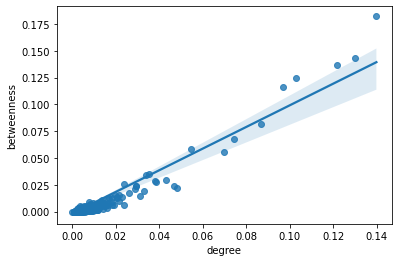

In [116]:
sns.regplot(x=df['degree'], y=df['betweenness'])

In [120]:
df.corr(method="pearson")

,rendimento,_x,_y,degree,betweenness,closeness,eigenvector,coefficient
rendimento,1.000000,-0.012052,-0.082556,0.017876,0.013988,0.065534,0.044235,-0.015985
_x,-0.012052,1.000000,-0.043618,0.002101,-0.000673,-0.051347,-0.011389,-0.024224
_y,-0.082556,-0.043618,1.000000,0.001623,0.000630,0.027106,0.059020,0.022502
degree,0.017876,0.002101,0.001623,1.000000,0.957321,0.307088,0.895117,-0.469832
betweenness,0.013988,-0.000673,0.000630,0.957321,1.000000,0.223479,0.804457,-0.299067
closeness,0.065534,-0.051347,0.027106,0.307088,0.223479,1.000000,0.493095,-0.399568
eigenvector,0.044235,-0.011389,0.059020,0.895117,0.804457,0.493095,1.000000,-0.540424
coefficient,-0.015985,-0.024224,0.022502,-0.469832,-0.299067,-0.399568,-0.540424,1.000000


In [121]:
def linear_resplot(result):
    width, height = rcParams['figure.figsize']
    fig, axs = plt.subplots(1, 2, figsize=(2 * width, height))
    ax = sns.scatterplot(x=result.fittedvalues, y=result.resid, ax=axs[0])
    ax.axhline(0)
    sns.histplot(result.resid, ax=axs[1])
    plt.show()

In [124]:
model = smf.ols(data=df, formula='betweenness ~ rendimento')
result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            betweenness   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4668
Date:                Wed, 17 Nov 2021   Prob (F-statistic):              0.495
Time:                        03:20:05   Log-Likelihood:                 8324.4
No. Observations:                2387   AIC:                        -1.664e+04
Df Residuals:                    2385   BIC:                        -1.663e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0009      0.000      5.302      0.000       0.001       0.001
rendimento  5.841e-10   8.55e-10      0.683      0.495   -1.09e-09    2.26e-09
==============================================================================
Omnibus:                     4872.382   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10535618.300
Skew:                          16.787   Prob(JB):                         0.00
Kurtosis:                     326.733   Cond. No.                     2.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0.494547805


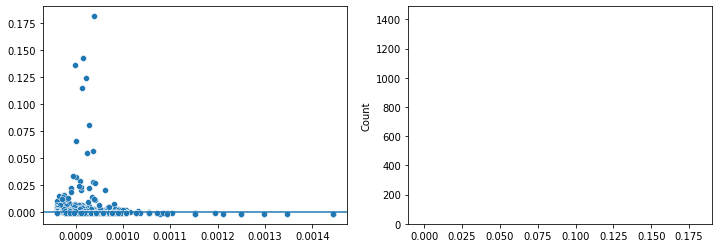

In [125]:
print(f"{result.pvalues['rendimento']:.09f}")
linear_resplot(result)